# 0. IMPORTS

## 0.1. Libraries

In [195]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from matplotlib      import gridspec
from tabulate        import tabulate
from scipy.stats     import chi2_contingency

pd.options.mode.chained_assignment = None  # default='warn'

## 0.2. Helper Functions

In [197]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency (cm )[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1 )))

## 0.3. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store')

## 0.4. Graph Visualization

In [3]:
from IPython.core.display import HTML

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [18, 8]
   plt.rcParams['font.size'] = 20
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )
   sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. DESCRIBE DATA

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
# list(df1.columns)

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# CamelCase to SnakeCase
snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [7]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
759717,73,1,2013-08-19,3805,536,1,0,0,0,a,c,1650.0,9.0,2008.0,0,NaN,NaN,NaN


In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance (2642 NAs)

# df1['competition_distance'].max() = 75860.0

df1['competition_distance'] = df1['competition_distance'].fillna(200000)


# competition_open_since_month (323348 NAs)
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)
# similarly: df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


# competition_open_since_year (323348 NAs)
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)


# promo2_since_week (508031 NAs)
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.week)


# promo2_since_year (508031 NAs)
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)


# promo_interval (508031 NAs)
month_map = {1: 'Jan',
             2: 'Feb',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sep',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

# New variable: check if sales date was in the period of promotion
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

<ipython-input-10-669cc2e20aaf>:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.week)


## 1.6. Change Data Type

In [11]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Variables

In [13]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.mean())
ct2 = pd.DataFrame(num_attributes.median())

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.std())
d2 = pd.DataFrame(num_attributes.min())
d3 = pd.DataFrame(num_attributes.max())
d4 = pd.DataFrame(num_attributes.max() - num_attributes.min())
d5 = pd.DataFrame(num_attributes.skew())
d6 = pd.DataFrame(num_attributes.kurtosis())

# concat
df_num = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6], axis = 1)
df_num.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_num

,mean,median,std,min,max,range,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,115.0,-7.235657,124.071304


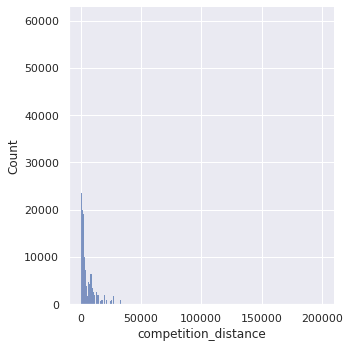

In [14]:
sns.displot(df1['competition_distance'], kde = False);

### 1.7.2. Categorical Variables

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

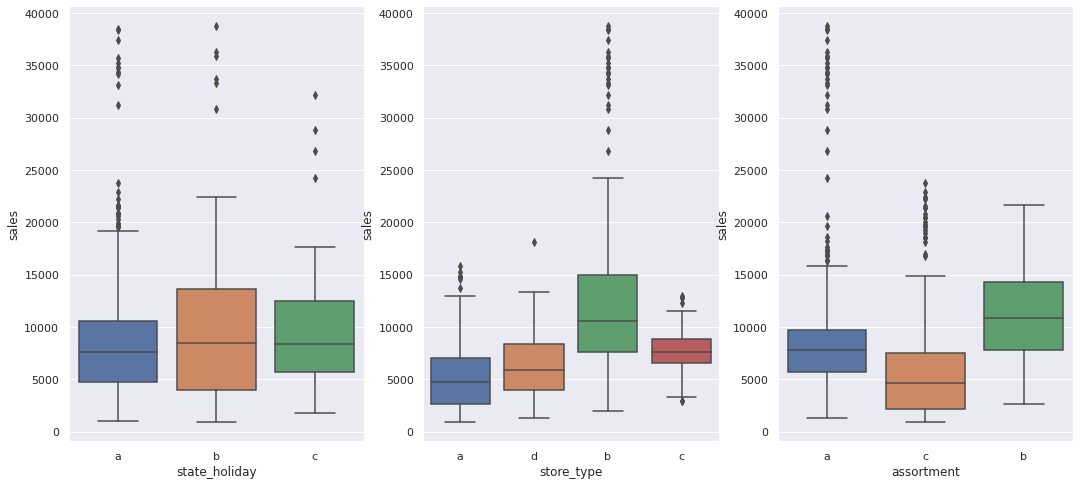

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] # filtering data for better visualization

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);

# 2. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

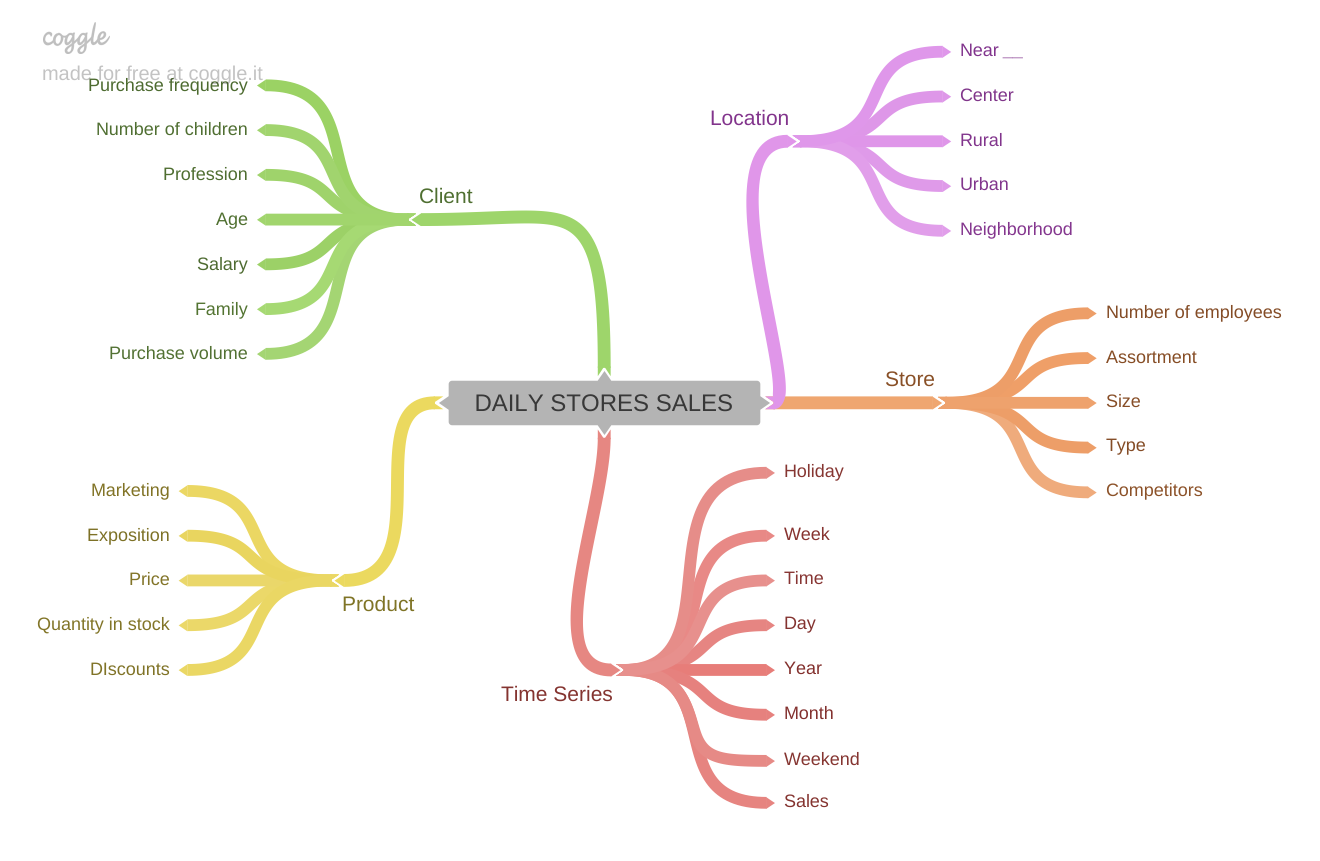

In [18]:
Image(filename='Daily_Store_Sales.png')

## 2.2. Hypothesis Development

Creation of hypothesis for each category in the Mind Map, while related to the response variable << **sales** >> .

PS.: Clients & Location: none information on dataset

### 2.2.1. Store Hypothesis

**1.** Stores with **more diversified products** should sell **more**

**2.** Stores with **closer competitors** should sell **less**

### 2.2.2. Product Hypothesis

**1.** Stores with **longer active promotions** should sell **more**

**2.** Stores with **more consecutive promotions** should sell **more**

### 2.2.3. Time Series Hypothesis

**1.** Stores, during **school holidays**, should sell **more**

**2.** Stores, in **Christmas period**, should sell **more** than during other holidays

**3.** Stores, during **weekends**, should sell **less**

**4.** At the **first half of the month**, stores should sell **more**

**5** In the **first semester of the year**, stores should sell **less**

**6.** **Throughout the years**, stores should sell **more**.

## 2.3. Feature Engineering

### 2.3.1. Created Columns

In [146]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year'] = df2['date'].dt.week

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

###

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

<ipython-input-146-86fe9e2cae40>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.week


### 2.3.2. Modified Columns

In [20]:
# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# 3. FILTERING VARIABLES

In [147]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [23]:
cols_drop = ['customers', 'open', 'competition_open_since_month' , 'competition_open_since_year', 'promo2_since_week',
             'promo2_since_year', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4. EXPLORATORY DATA ANALYSIS (EDA)

In [148]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

/home/diandramelo/.pyenv/versions/3.8.0/envs/RossmannStoreSales/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


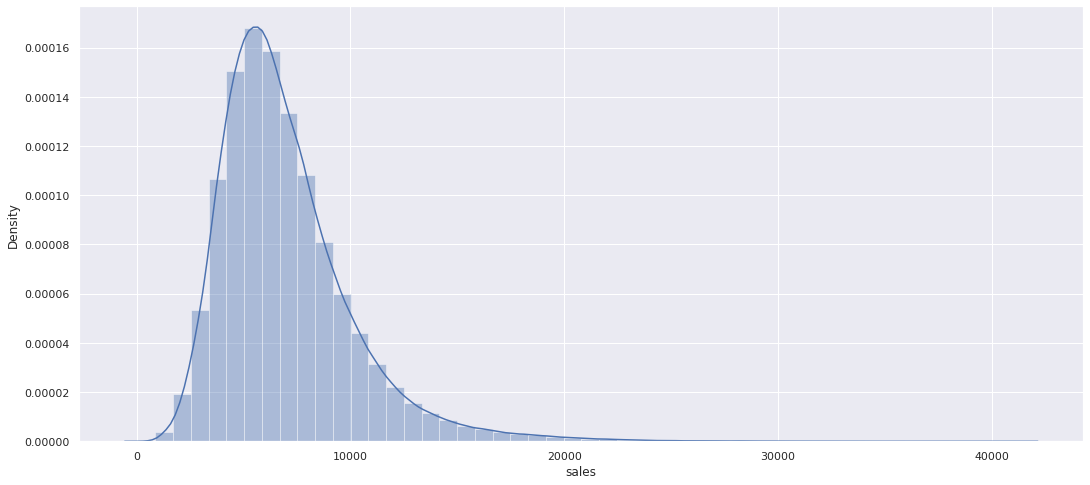

In [25]:
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variables

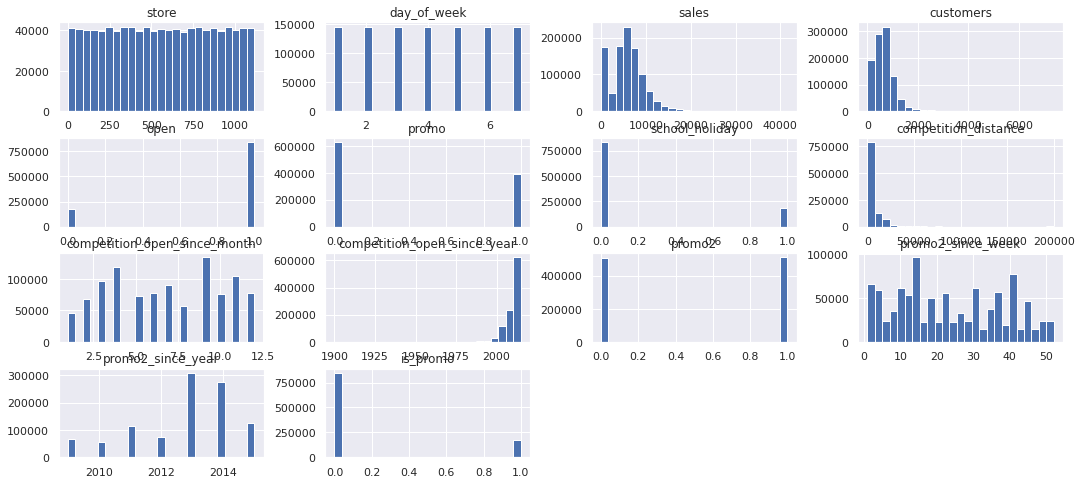

In [26]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variables

/home/diandramelo/.pyenv/versions/3.8.0/envs/RossmannStoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/diandramelo/.pyenv/versions/3.8.0/envs/RossmannStoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/diandramelo/.pyenv/versions/3.8.0/envs/RossmannStoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and

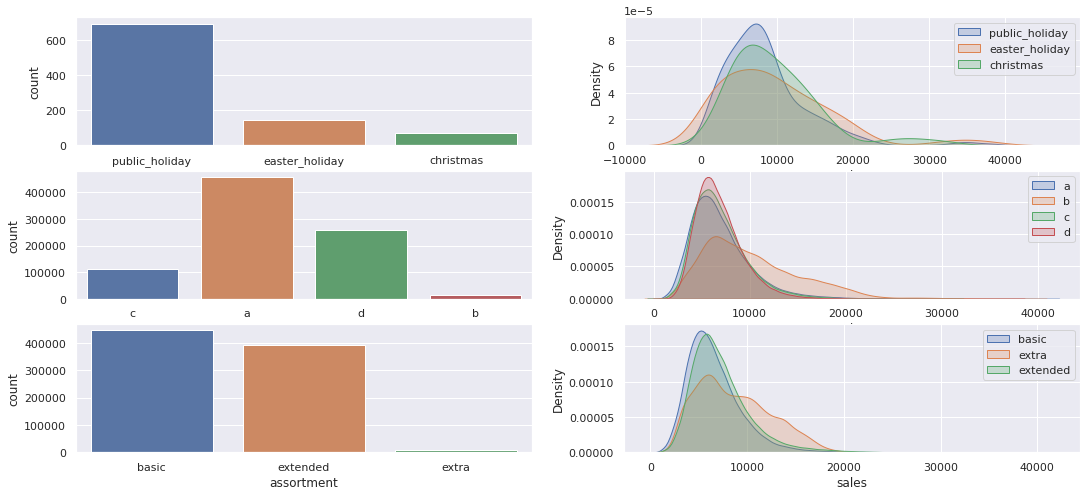

In [27]:
# state_holiday
aux1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3, 2, 1)
sns.countplot(aux1['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True, label = 'public_holiday');
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True, label = 'easter_holiday');
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade = True, label = 'christmas');
plt.legend();


# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade = True, label = 'a');
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade = True, label = 'b');
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade = True, label = 'c');
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade = True, label = 'd');
plt.legend();


# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade = True, label = 'basic');
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade = True, label = 'extra');
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade = True, label = 'extended');
plt.legend();

## 4.2. Bivariate Analysis - Hypothesis Validation

### 4.2.1. Individual Analysis of the Hypothesis

**H1.** Stores with **more diversified products** should sell **more**

**TRUE**, when compared to basic assortment, although extended assortment does not sell more than extra

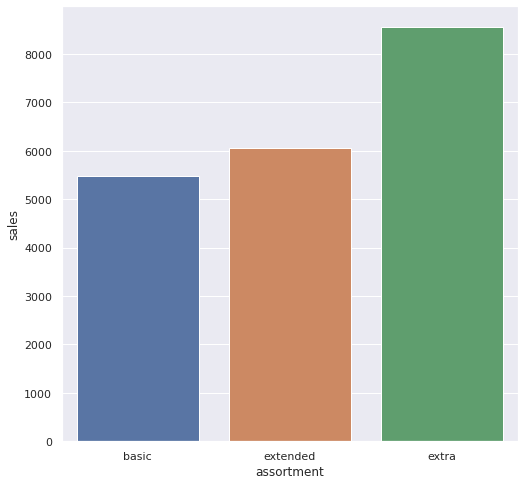

In [177]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

**H2.** Stores with **closer competitors** should sell **less**

**FALSE** - sales do not vary much

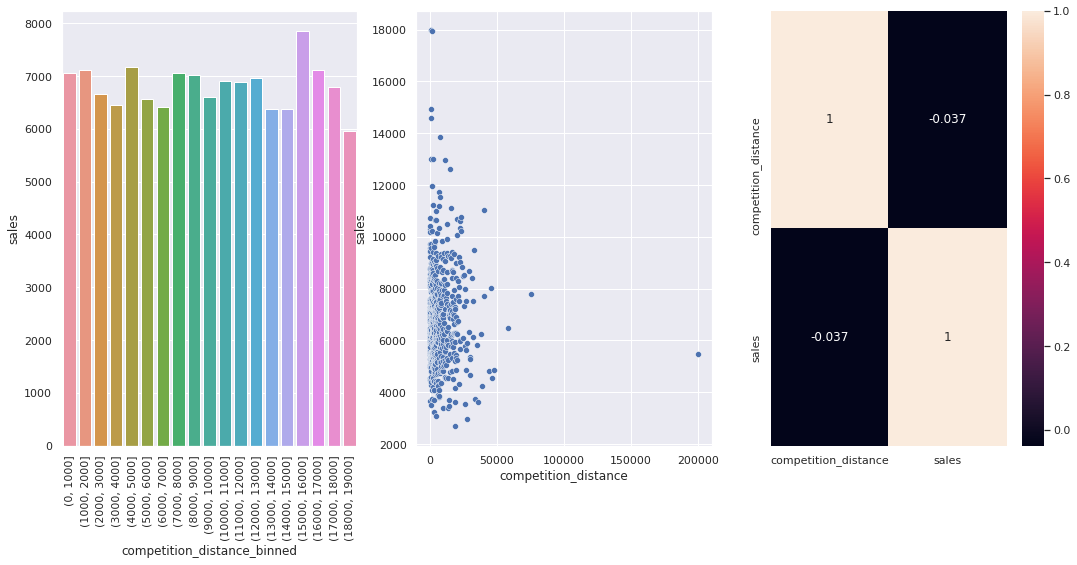

In [75]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1, 3, 1)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H3.** Stores with **longer active promotions** should sell **more**

**TRUE** - There is a tendency of more average sales for stores with longer periods of promotion

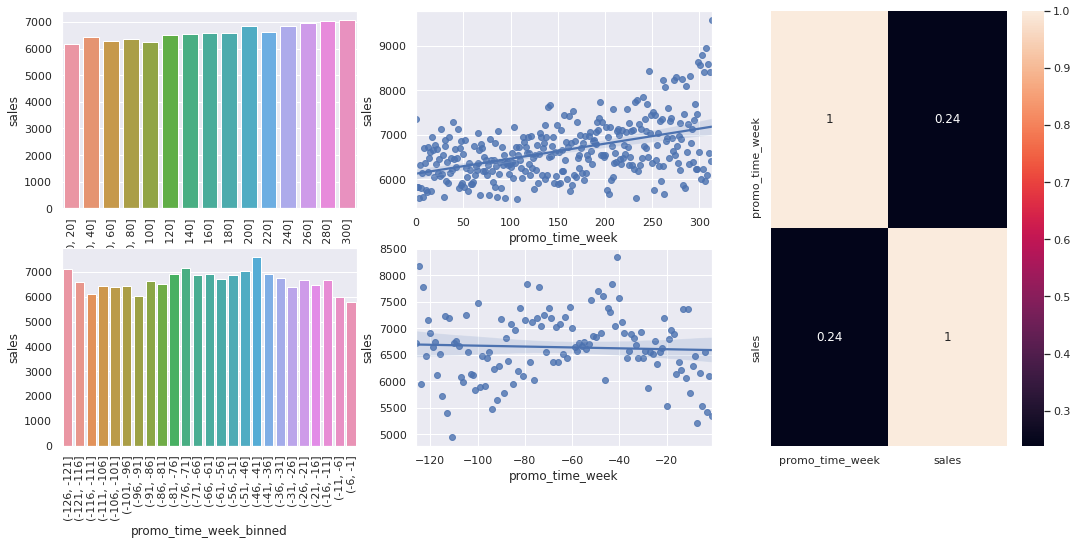

In [87]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

grid = gridspec.GridSpec(2,3)


# extended promotion
aux2 = aux1.loc[(aux1['promo_time_week'] >= 0), :]

plt.subplot(grid[0,0])
bins = list(np.arange(0,313,20))
aux2['promo_time_week_binned'] = pd.cut(aux2['promo_time_week'], bins = bins)
aux3 = aux2[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot(x = 'promo_time_week_binned', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);


# regular promotion
aux4 = aux1[aux1['promo_time_week'] < 0]

plt.subplot(grid[1,0])
bins = list(np.arange(-126,0,5))
aux4['promo_time_week_binned'] = pd.cut(aux4['promo_time_week'], bins = bins)
aux5 = aux4[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot(x = 'promo_time_week_binned', y = 'sales', data = aux5);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux4);


plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H4.** Stores with **more consecutive promotions** should sell **more**

**FALSE** - Stores with regular promotions only sell more

In [94]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


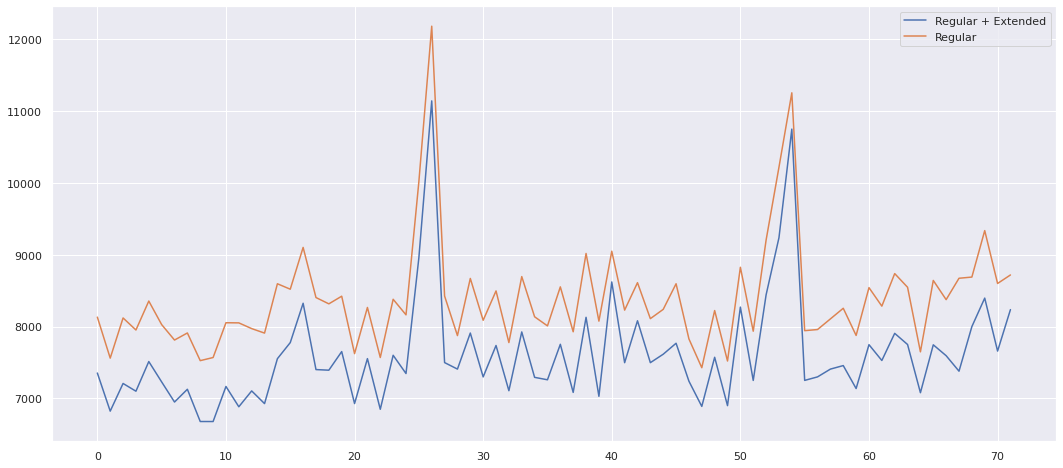

In [105]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Regular + Extended', 'Regular']);

**H5.** Stores, during **school holidays**, should sell **more**

**TRUE**, except for the months of January, April, November and December

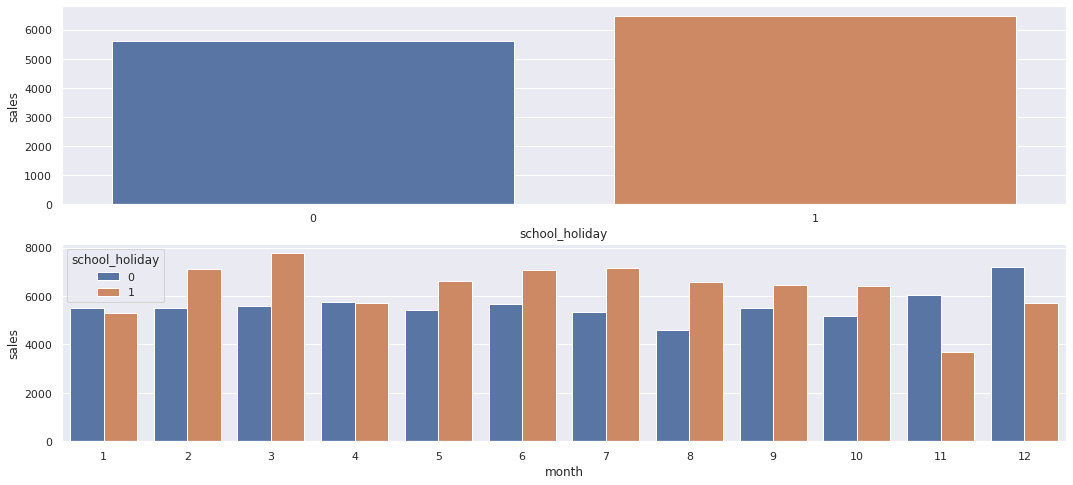

In [121]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

# analysis per month
plt.subplot(2, 1, 2)
aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).mean().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

**H6.** Stores, in **Christmas period**, should sell **more** than during other holidays

**FALSE** - Stores sell less in Christmas than in public holiday or easter

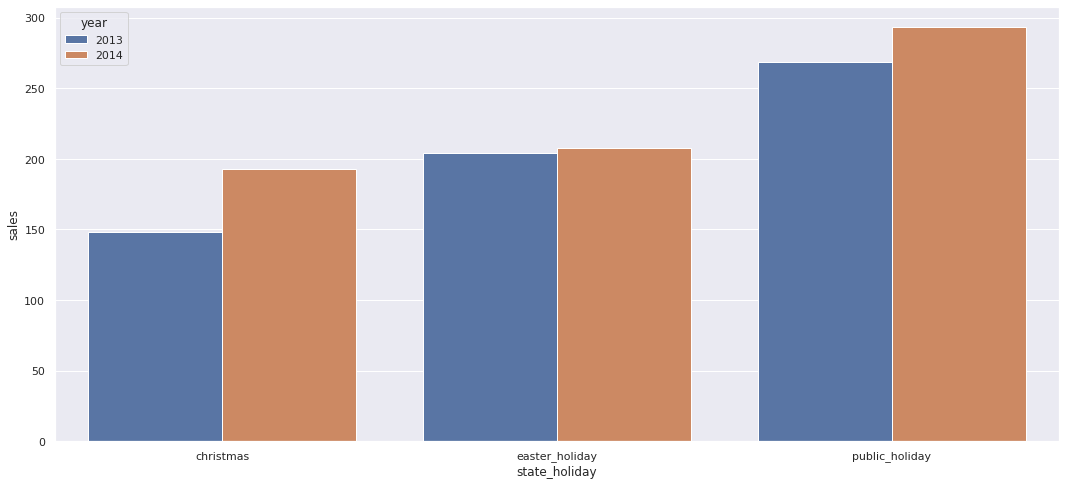

In [138]:
# 2015 removed - data is only until 31/07/2015

aux1 = df4[(df4['state_holiday'] != 'regular_day') & (df4['year'] < 2015)]

aux2 = aux1[['state_holiday', 'year', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()

sns.barplot(x = 'state_holiday', y = 'sales', hue = 'year', data = aux2);

**H7.** Stores, during **weekends**, should sell **less**

**TRUE**

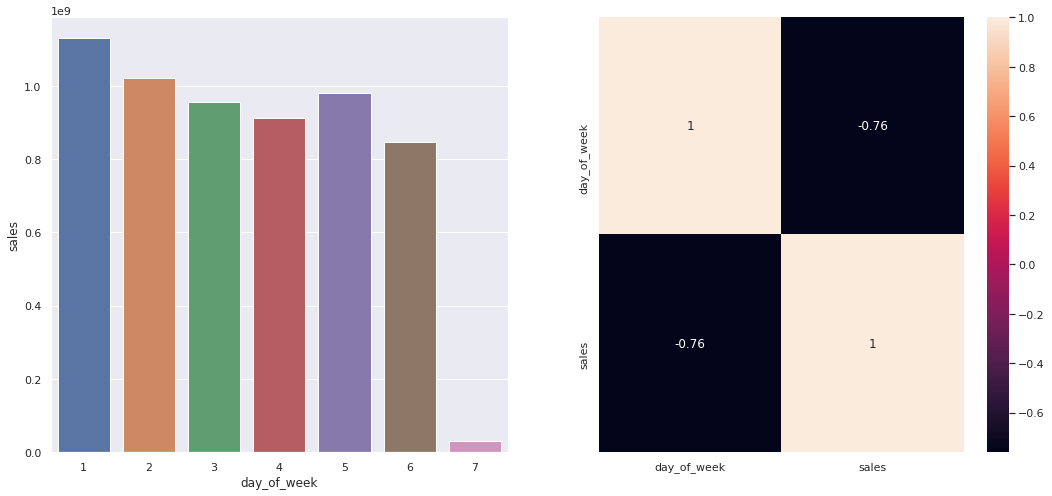

In [144]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H8.** At the **first half of the month**, stores should sell **more**

**TRUE**

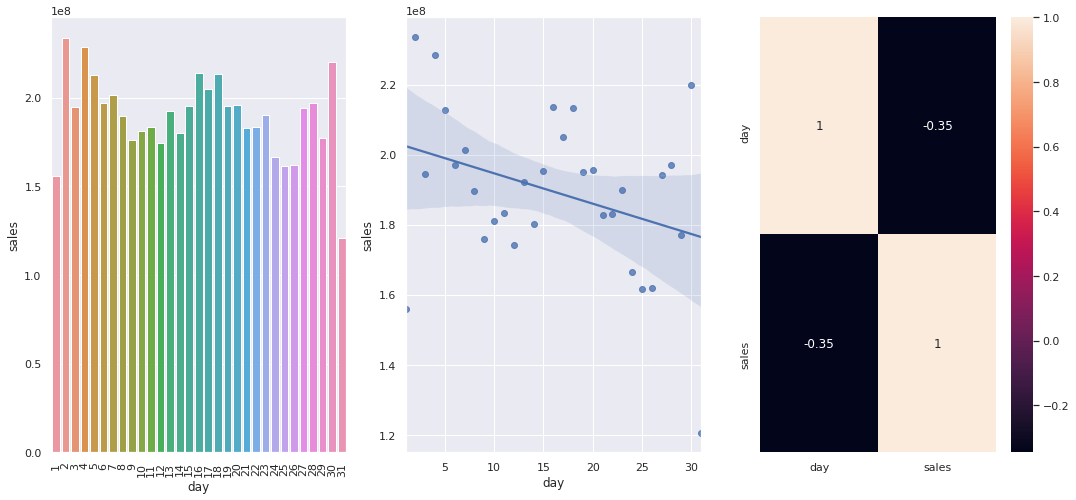

In [154]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H9.** In the **first semester of the year**, stores should sell **less**

**TRUE** - Analysis for the years of 2013 and 2014 (the data from 2015 stops in july)

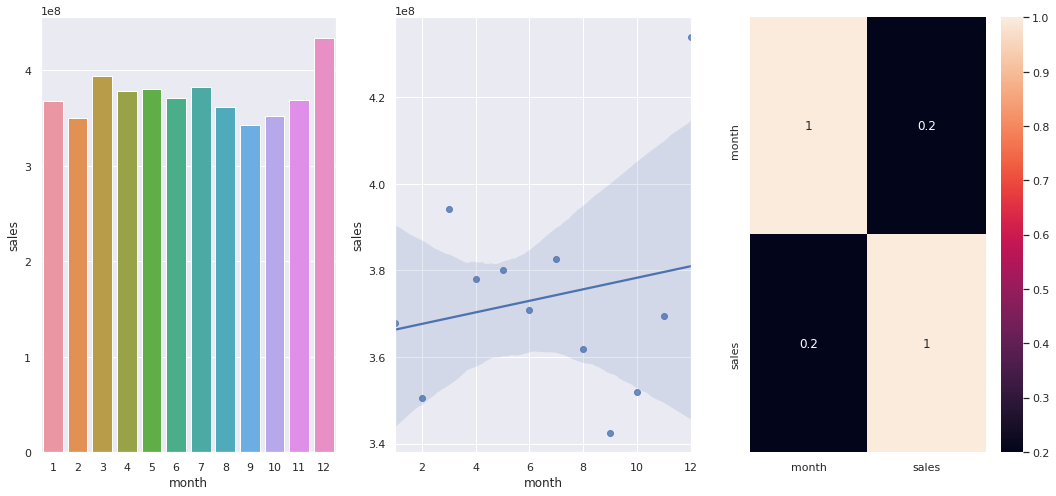

In [165]:
# 2015 removed - data only until 31/07/2015

aux = df4[df4['year'] < 2015]

aux1 = aux[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H10.** **Throughout the years**, stores should sell **more**

**FALSE** - Even though data of 2015 is incomplete, it was considered to observe the tendency of sales reduction throughout years

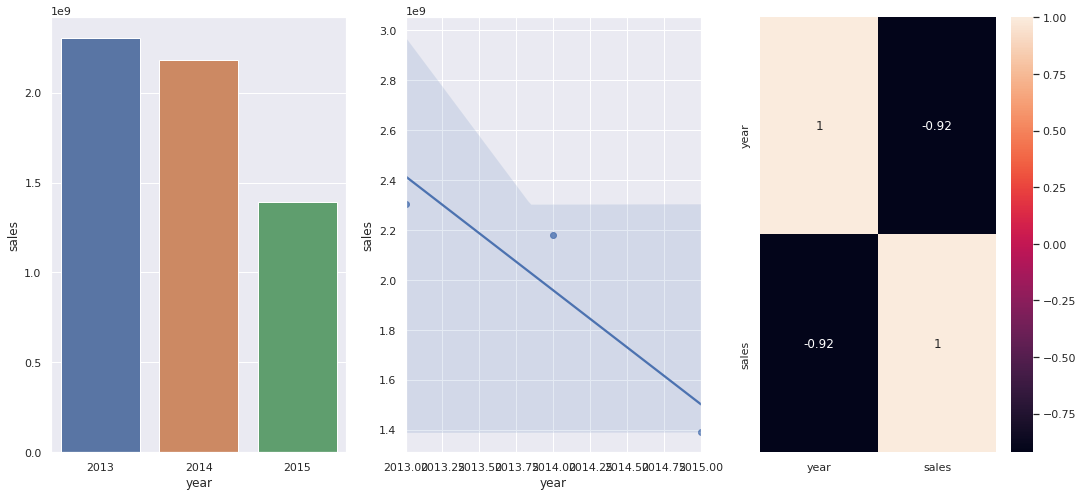

In [169]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### 4.2.2. General Hypothesis Review

In [178]:

tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1 - Stores with more diversified products should sell more', 'True', 'Medium'],
       ['H2 - Stores with closer competitors should sell less', 'False', 'Low'],
       ['H3 - Stores with longer active promotions should sell more', 'True', 'Medium'],
       ['H4 - Stores with more consecutive promotions should sell more', 'False', 'Low'],
       ['H5 - Stores, during school holidays, should sell more', 'True', 'Low'],
       ['H6 - Stores, in Christmas period, should sell more than during other holidays', 'False', 'Medium'],
       ['H7 - Stores, during weekends, should sell less', 'True', 'High'],
       ['H8 - At the first half of the month, stores should sell more', 'True', 'High'],
       ['H9 - In the first semester of the year, stores should sell less', 'True', 'High'],
       ['H10 - Throughout the years, stores should sell more', 'False', 'High']
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis                                                                     Conclusion    Relevance
-----------------------------------------------------------------------------  ------------  -----------
H1 - Stores with more diversified products should sell more                    True          Medium
H2 - Stores with closer competitors should sell less                           False         Low
H3 - Stores with longer active promotions should sell more                     True          Medium
H4 - Stores with more consecutive promotions should sell more                  False         Low
H5 - Stores, during school holidays, should sell more                          True          Low
H6 - Stores, in Christmas period, should sell more than during other holidays  False         Medium
H7 - Stores, during weekends, should sell less                                 True          High
H8 - At the first half of the month, stores should sell more                   True          High
H9 - 

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

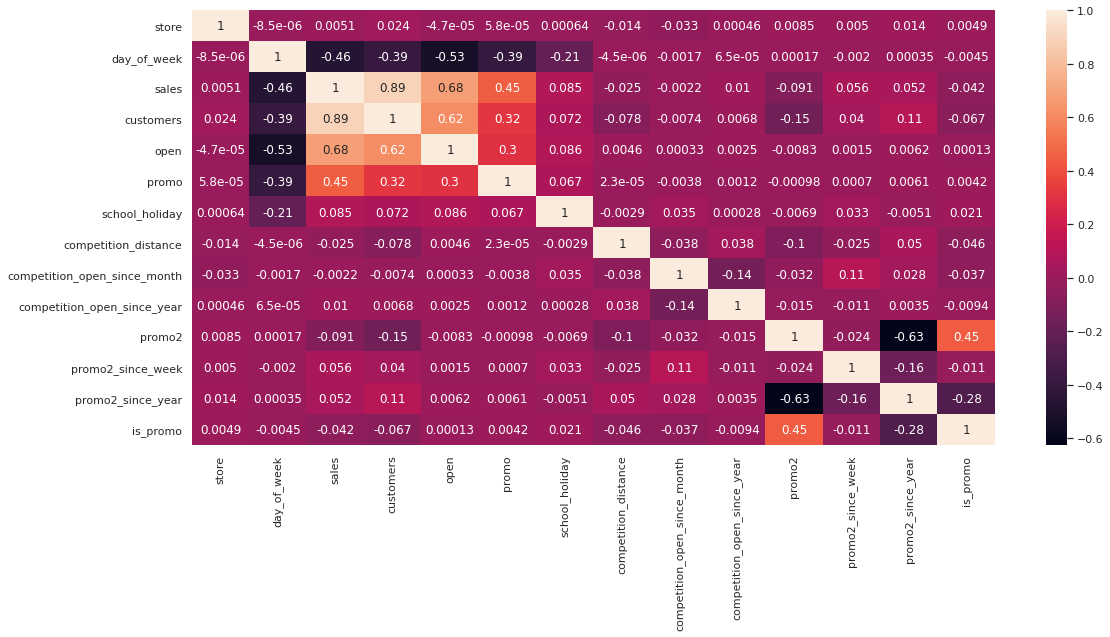

In [182]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Attributes

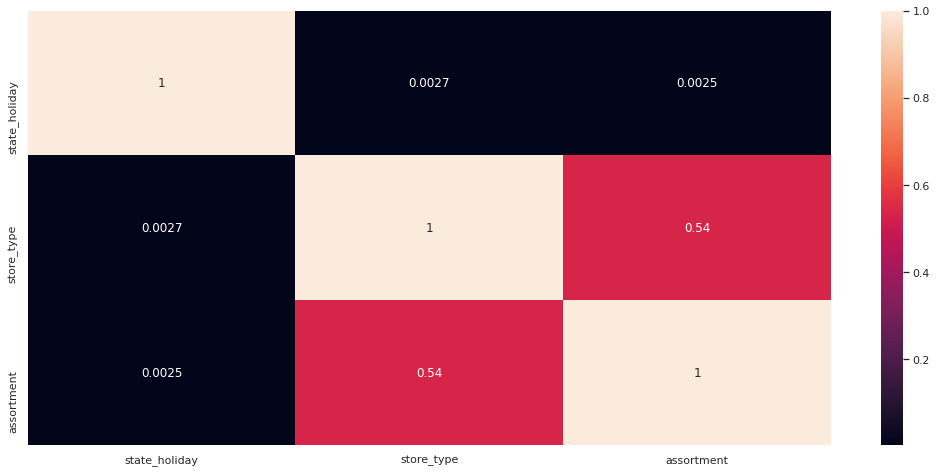

In [198]:
a = df4.select_dtypes(include='object')

# calculating cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3], 
                  'store_type':[a4,a5,a6],
                  'assortment':[a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5. DATA PREPARATION